In [1]:
# imports
import os
import shutil
from pathlib import Path
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

In [2]:
#  install tensorflow with conda
#  conda install -c conda-forge tensorflow  

import tensorflow as tf

In [15]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.17.0


In [6]:
import keras as keras

In [17]:
print("Keras version:", keras.__version__)

Keras version: 3.5.0


In [24]:
# tensorflow imports
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [8]:
root_dir = Path.cwd()

# Define the images directory
images_dir = root_dir / 'data' / 'images'

# Define the output directories
train_dir = root_dir / 'data' / 'training'
test_dir = root_dir / 'data' / 'test'

# Define the classes based on filename prefixes
classes = ['level0', 'level1', 'level2', 'level3']

prefix_mapping = {
    'level0': 'levle0_',
    'level1': 'levle1_',
    'level2': 'levle2_',
    'level3': 'levle3_'
}


In [9]:
# ensures that the training and test directories, along with their class subdirectories, exist.

for split_dir in [train_dir, test_dir]:
    for cls in classes:
        class_path = split_dir / cls
        class_path.mkdir(parents=True, exist_ok=True)

In [10]:
# Function to Split and Copy Images
def split_and_copy_images():
    for cls in classes:
        # Get the corresponding prefix for the current class
        cls_prefix = prefix_mapping.get(cls)
        
        if not cls_prefix:
            print(f"No prefix defined for class '{cls}'. Skipping.")
            continue
        
        # Retrieve all images belonging to the current class
        cls_images = [img for img in images_dir.iterdir() if img.is_file() and img.name.startswith(cls_prefix)]
        
        # Split the images into training and testing sets (75% train, 25% test)
        train_images, test_images = train_test_split(
            cls_images, 
            test_size=0.25, 
            random_state=42,  # Ensures reproducibility
            shuffle=True
        )
        
        # Copy training images
        for img_path in train_images:
            destination = train_dir / cls / img_path.name
            shutil.copy(img_path, destination)
        
        # Copy testing images
        for img_path in test_images:
            destination = test_dir / cls / img_path.name
            shutil.copy(img_path, destination)
        
        print(f"Class '{cls}': {len(train_images)} training and {len(test_images)} testing images copied.")

# Execute the function
split_and_copy_images()

print("All images have been successfully split into training and test sets.")

Class 'level0': 372 training and 125 testing images copied.
Class 'level1': 477 training and 160 testing images copied.
Class 'level2': 139 training and 47 testing images copied.
Class 'level3': 102 training and 35 testing images copied.
All images have been successfully split into training and test sets.


In [11]:
# Get the class names for our multi-class dataset
class_names = np.array(sorted([item.name for item in train_dir.glob('*')]))
print(class_names)

['level0' 'level1' 'level2' 'level3']


In [12]:
# View an image
def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = Path(target_dir) / target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)[0]

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder / random_image)
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (3264, 4912, 3)


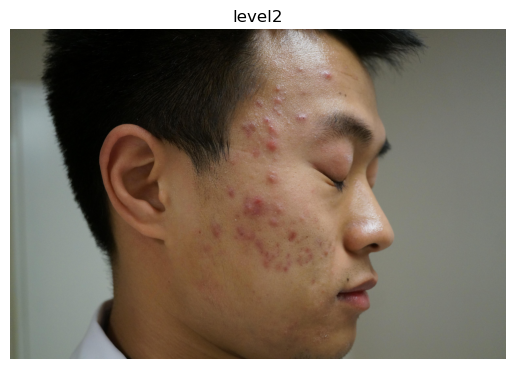

In [13]:
# View a random image from the training dataset
img = view_random_image(target_dir=train_dir,
                        target_class=random.choice(classes)) # get a random class name

In [14]:
# Create datasets using image_dataset_from_directory
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 image_size=(224, 224),
                                                                 batch_size=32,
                                                                 label_mode='categorical', # for multi-class classification
                                                                 shuffle=True)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=(224, 224),
                                                                batch_size=32,
                                                                label_mode='categorical')

# Data augmentation 
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

# Normalization layer 
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Apply data augmentation and normalization to training data
train_data = train_data.map(lambda x, y: (data_augmentation(x, training=True), y))
train_data = train_data.map(lambda x, y: (normalization_layer(x), y))

# Apply normalization to test data
test_data = test_data.map(lambda x, y: (normalization_layer(x), y))

# Prefetch data for better performance (overlap data preprocessing and model execution)
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.prefetch(buffer_size=AUTOTUNE)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)


Found 1090 files belonging to 4 classes.
Found 367 files belonging to 4 classes.


In [25]:
# Create baseline model
model_baseline = Sequential([
    Input(shape=(224, 224, 3)),  # Define input shape using Input layer
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.3),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.4),

    GlobalAveragePooling2D(), 
    Dense(64, activation='relu'),
    Dropout(0.5),  # Increased dropout before output layer
    Dense(4, activation='softmax')  # 4 neurons for the 4 classes
])

# Compile the model with a learning rate scheduler
model_baseline.compile(loss="categorical_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])


model_baseline.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 220, 220, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 108, 108, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 108, 108, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 106, 106, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 51, 51, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 49, 49, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 296,420 (1.13 MB)

 Trainable params: 295,972 (1.13 MB)

 Non-trainable params: 448 (1.75 KB)

In [29]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', 
                                 factor=0.5, 
                                 patience=3, 
                                 verbose=1, 
                                 min_lr=1e-6)

# Optional: Set up a model checkpoint to save the best model
checkpoint = ModelCheckpoint('best_model.keras', 
                             monitor='val_accuracy', 
                             save_best_only=True, 
                             mode='max', 
                             verbose=1)

In [37]:
# Fit the model with callbacks
history = model_baseline.fit(train_data, 
                         epochs=10, 
                         validation_data=test_data, 
                         callbacks=[lr_scheduler, checkpoint])

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 989ms/step - accuracy: 0.4478 - loss: 1.1338
Epoch 1: val_accuracy did not improve from 0.43597
35/35 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.4475 - loss: 1.1342 - val_accuracy: 0.4360 - val_loss: 1.3176 - learning_rate: 0.0010
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 989ms/step - accuracy: 0.4368 - loss: 1.1238
Epoch 2: val_accuracy improved from 0.43597 to 0.44959, saving model to best_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.4370 - loss: 1.1241 - val_accuracy: 0.4496 - val_loss: 1.3796 - learning_rate: 0.0010
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 988ms/step - accuracy: 0.4781 - loss: 1.1316
Epoch 3: val_accuracy did not improve from 0.44959
35/35 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.4777 - loss: 1.1321 - val_accuracy: 0.4387 - val_loss: 1.3437 - learning_rate: 0.0010
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 990ms/step - accuracy: 0.4404 - loss: 1.1135
Epoch 4: ReduceLROnPlateau reducing learning rat

In [38]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """ 
    # Extract loss and accuracy from the history
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(loss))  # Get the number of epochs

    # Plot loss
    plt.figure(figsize=(12, 5))  # Set figure size for better readability
    plt.subplot(1, 2, 1)  # Create a subplot for loss
    plt.plot(epochs, loss, label='Training Loss', color='blue')
    plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)  # Add a grid for better visibility

    # Plot accuracy
    plt.subplot(1, 2, 2)  # Create a subplot for accuracy
    plt.plot(epochs, accuracy, label='Training Accuracy', color='green')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='red')
    plt.title('Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)  # Add a grid for better visibility

    plt.tight_layout()  # Adjust the layout to prevent overlap
    plt.show()  # Display the plots


In [39]:
# Evaluate on the test data
model_baseline.evaluate(test_data)

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step - accuracy: 0.4664 - loss: 1.2688


[1.2846068143844604, 0.4332424998283386]

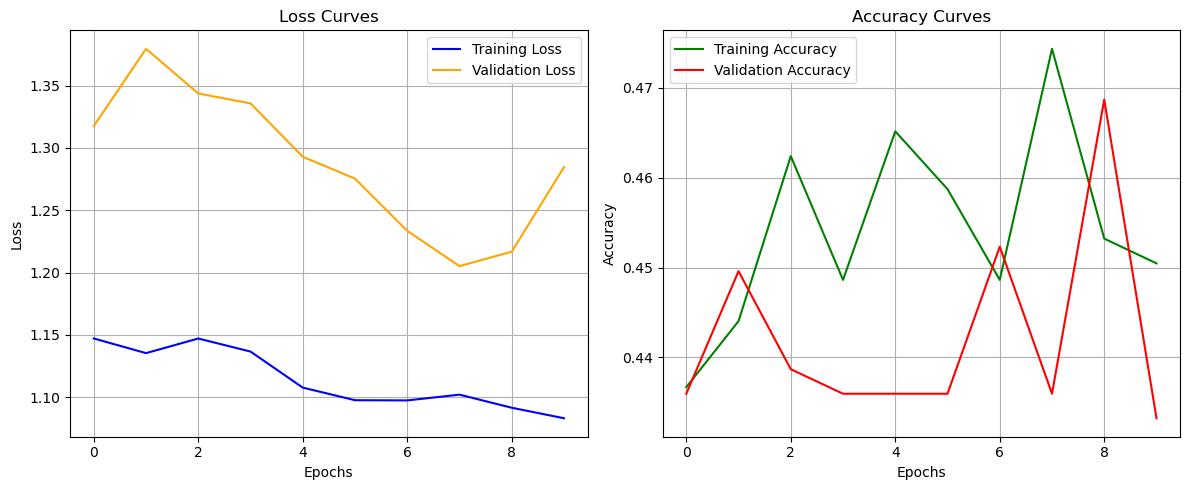

In [40]:
# Check out the model's loss curves on the 4 classes of data 
plot_loss_curves(history)